# Desenvolvido por



> Gabriel de Lima Miranda - 22304286


> Armando Vítor Oliveira de Lima - 22301333





# Objetivo da Exploração

## Relacionamento entre Condições de Saúde e COVID-19:

> Análise das mortes por diferentes condições de saúde (obesidade, atividade física, nutrição) em relação às mortes por COVID-19.

# Código

In [ ]:
# Bibliotecas
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Inicialize a sessão do Spark
spark = SparkSession.builder.appName("ExploracaoDadosCOVID").getOrCreate()

In [ ]:
# 1. Leitura dos Dados
# Leitura dos dados de condições de contribuição para mortes por COVID-19 e nutrição
conditions_df = spark.read.csv("Conditions_Contributing_to_COVID-19_Deaths__by_State_and_Age__Provisional_2020-2023.csv", header=True)
nutrition_df = spark.read.csv("Nutrition__Physical_Activity__and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System.csv", header=True)

In [ ]:
# 2. Exploração Inicial
# Imprime a estrutura do esquema (schema) dos dataframes
conditions_df.printSchema()
nutrition_df.printSchema()

root
 |-- Data As Of: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- End Date: string (nullable = true)
 |-- Group: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Condition Group: string (nullable = true)
 |-- Condition: string (nullable = true)
 |-- ICD10_codes: string (nullable = true)
 |-- Age Group: string (nullable = true)
 |-- COVID-19 Deaths: string (nullable = true)
 |-- Number of Mentions: string (nullable = true)
 |-- Flag: string (nullable = true)

root
 |-- YearStart: string (nullable = true)
 |-- YearEnd: string (nullable = true)
 |-- LocationAbbr: string (nullable = true)
 |-- LocationDesc: string (nullable = true)
 |-- Datasource: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Topic: string (nullable = true)
 |-- Question: string (nullable = true)
 |-- Data_Value_Unit: string (nullable = true)
 |-- Data_Value_Type: string (nullable = t

In [ ]:
# 3. Seleção de Colunas Relevantes
# Seleção das colunas relevantes para análise de condições e nutrição
conditions_selected_cols = conditions_df.select('State', 'Age Group', 'Condition', 'COVID-19 Deaths')
nutrition_selected_cols = nutrition_df.select('LocationDesc', 'Age(years)', 'Class', 'Topic', 'Question', 'Data_Value')

In [ ]:
# 4. Renomeação de Colunas para Padronização
# Renomeação de colunas para padronização antes da junção
conditions_renamed_cols = conditions_selected_cols.withColumnRenamed('Age Group', 'AgeGroup_conditions')
nutrition_renamed_cols = nutrition_selected_cols.withColumnRenamed('Age(years)', 'AgeGroup_nutrition')

In [ ]:
# 5. Junção dos Dados
# Junção dos dataframes de condições e nutrição baseada em algumas condições
combined_data = conditions_renamed_cols.join(
    nutrition_renamed_cols,
    (conditions_renamed_cols.State == nutrition_renamed_cols.LocationDesc) &
    (conditions_renamed_cols.AgeGroup_conditions == nutrition_renamed_cols.AgeGroup_nutrition),
    "outer"
)

In [ ]:
# Exiba algumas amostras dos dados
combined_data.show(10)

+-----+-------------------+---------+---------------+------------+------------------+--------------------+--------------------+--------------------+----------+
|State|AgeGroup_conditions|Condition|COVID-19 Deaths|LocationDesc|AgeGroup_nutrition|               Class|               Topic|            Question|Data_Value|
+-----+-------------------+---------+---------------+------------+------------------+--------------------+--------------------+--------------------+----------+
| NULL|               NULL|     NULL|           NULL|     Alabama|           18 - 24|Obesity / Weight ...|Obesity / Weight ...|Percent of adults...|      24.9|
| NULL|               NULL|     NULL|           NULL|     Alabama|           18 - 24|Obesity / Weight ...|Obesity / Weight ...|Percent of adults...|      19.3|
| NULL|               NULL|     NULL|           NULL|     Alabama|           18 - 24|   Physical Activity|Physical Activity...|Percent of adults...|      22.2|
| NULL|               NULL|     NULL|   

In [ ]:
# 6. Limpeza e Pré-processamento
# Filtra linhas onde State, AgeGroup_conditions e COVID-19 Deaths não são nulos
combined_data = combined_data.filter((col('State').isNotNull()) & (col('AgeGroup_conditions').isNotNull()) & (col('COVID-19 Deaths').isNotNull()))

In [ ]:
# 7. Análise do Relacionamento
# Converte a coluna 'COVID-19 Deaths' para double e calcula a média por condição
combined_data = combined_data.withColumn('COVID-19 Deaths', col('COVID-19 Deaths').cast('double'))
analysis_result = combined_data.groupBy('Condition').agg({'COVID-19 Deaths': 'mean'})

In [ ]:
mó# Converta o resultado da análise para um DataFrame pandas
result_pd = analysis_result.toPandas()

In [ ]:
# Ordene os dados para tornar o gráfico mais legível
result_pd = result_pd.sort_values(by='avg(COVID-19 Deaths)', ascending=False)

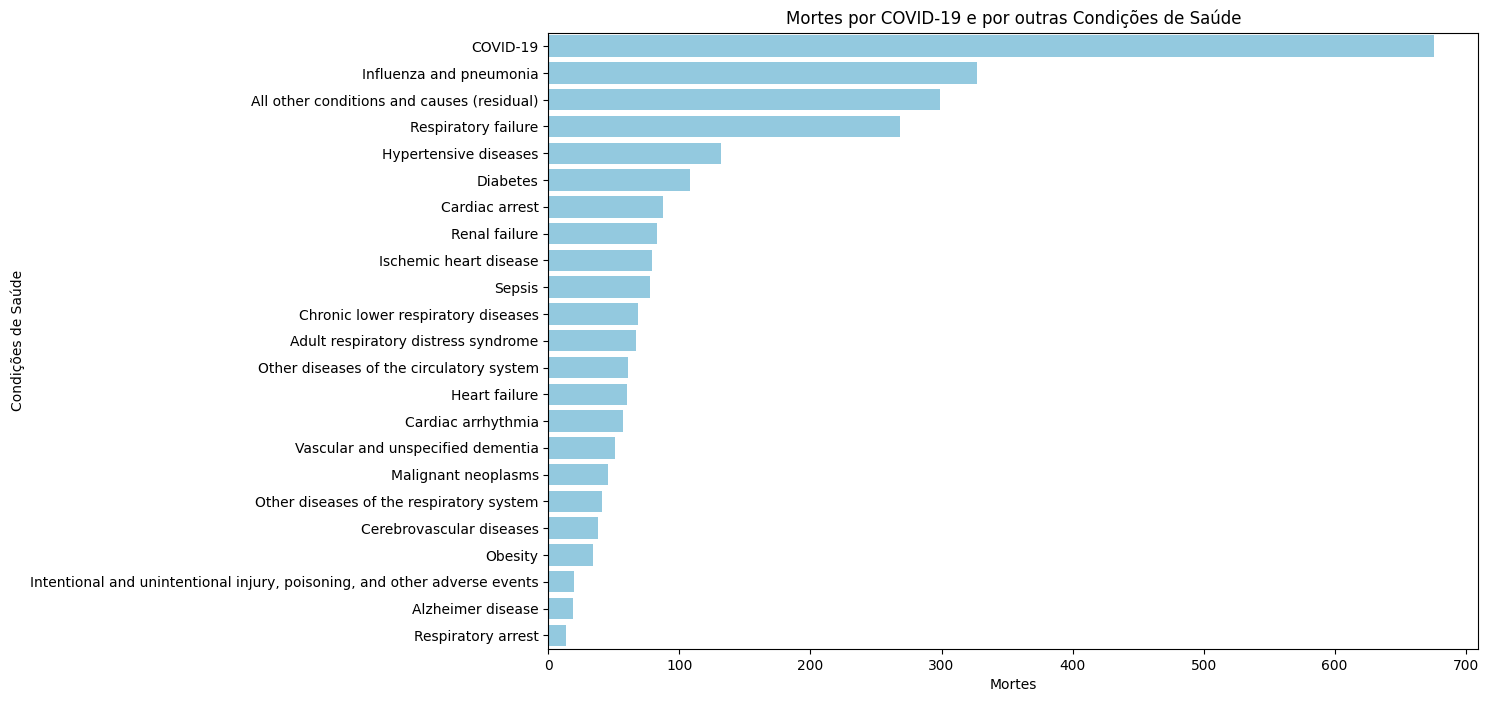

In [ ]:
# 8. Visualização dos Resultados
# Crie um gráfico de barras horizontal para visualizar as relações entre condições e mortes por COVID-19
plt.figure(figsize=(12, 8))
sns.barplot(x='avg(COVID-19 Deaths)', y='Condition', data=result_pd, color='skyblue')
plt.title('Mortes por COVID-19 e por outras Condições de Saúde')
plt.xlabel('Mortes')
plt.ylabel('Condições de Saúde')
plt.show()

In [ ]:
# Encerre a sessão do Spark
spark.stop()